In [1]:
import numpy as np
import time
import pandas as pd

# Pour charger les modèles
import tensorflow as tf
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB3, EfficientNetB7,
    ResNet50, ResNet101,
    VGG16, VGG19
)

# Pour importer le datasets
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# pour serialisation des preprocessing
from keras.saving import register_keras_serializable

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 32
class_names = sorted(os.listdir(dir_name))
NB_CLASSES = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

test_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

2025-04-22 21:27:10.226600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745350030.385421    1441 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745350030.434960    1441 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745350030.805311    1441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745350030.805363    1441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745350030.805365    1441 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.


I0000 00:00:1745350065.680383    1441 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 54000 files belonging to 27 classes.
Using 10800 files for validation.
Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


In [ ]:
from keras.saving import register_keras_serializable

NB_EPOCH = 5

# couches personnalisées pour gérer le pré-traitement des images 
@register_keras_serializable()   
class VGG16Preprocess(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.applications.vgg16.preprocess_input(inputs)

@register_keras_serializable()   
class VGG19Preprocess(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.applications.vgg19.preprocess_input(inputs)

@register_keras_serializable()   
class RestNetPreprocess(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.keras.applications.resnet.preprocess_input(inputs)

@register_keras_serializable()   
class EfficientnetPreprocess(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EfficientnetPreprocess, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.keras.applications.efficientnet.preprocess_input(inputs)

# 📦 Fonction de construction du modèle
def build_keras_model(base_model_fn, preprocess = None, input_shape=(224, 224, 3), num_classes=27):
    base_model = base_model_fn(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'  # global average pooling
    )
    base_model.trainable = True  # fine-tuning ?

    inputs = tf.keras.Input(shape=input_shape)

    # Augmentation des données
    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.2)(x)
    x = tf.keras.layers.RandomZoom(0.2)(x)
    x = tf.keras.layers.RandomContrast(0.2)(x)

    # Preprocessing
    x = preprocess(x)
    #x = tf.keras.layers.Rescaling(1./255)(inputs)

    # modèle de base
    x = base_model(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

# 📊 Liste des modèles à benchmarker
models_to_test = {
    #"EfficientNetB0": lambda: build_keras_model(EfficientNetB0, num_classes=NB_CLASSES, preprocess = EfficientnetPreprocess() ),
    #"EfficientNetB3": lambda: build_keras_model(EfficientNetB3, num_classes=NB_CLASSES, preprocess = EfficientnetPreprocess()),
    #"EfficientNetB7": lambda: build_keras_model(EfficientNetB7, num_classes=NB_CLASSES, preprocess = EfficientnetPreprocess()),
    #"ResNet50": lambda: build_keras_model(ResNet50, num_classes=NB_CLASSES, preprocess = RestNetPreprocess()),
    #"ResNet101": lambda: build_keras_model(ResNet101, num_classes=NB_CLASSES, preprocess = RestNetPreprocess()),
    #"VGG16": lambda: build_keras_model(VGG16, num_classes=NB_CLASSES, preprocess = VGG16Preprocess()),
    #"VGG19": lambda: build_keras_model(VGG19, num_classes=NB_CLASSES, preprocess = VGG19Preprocess()),
}

# 📈 Boucle de benchmark
results = {}

for model_name, builder in models_to_test.items():
    print(f"\n🔄 Training model: {model_name}")
    model = builder() 
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=NB_EPOCH,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
                tf.keras.callbacks.ModelCheckpoint(
                    f'../../src/models/benchmark_keras/fine_tuned/{model_name}_model_best.keras',
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True,
                    save_weights_only=False
                )
            ]
        )
    
        duration = time.time() - start_time
        test_loss, test_acc = model.evaluate(test_ds)
    
        # ⚠️ Prédictions et F1-score
        y_true = []
        y_pred = []
        for images, labels in test_ds:
            preds = model.predict(images)
            y_true.extend(labels.numpy())
            y_pred.extend(np.argmax(preds, axis=1))
    
        f1 = f1_score(y_true, y_pred, average='macro')
    
        results[model_name] = {
            "Test Accuracy": round(test_acc, 4),
            "Test Loss": round(test_loss, 4),
            "F1 Score": round(f1, 4),
            "Params": model.count_params(),
            "Training Time (s)": int(duration)
        }
    
        # Sauvegarde du modèle final
        model.save(f'../../src/models/benchmark_keras/fine_tuned/{model_name}_model_final.keras')
        
    except Exception as e:
        print(f"Error training {model_name}: {e}")

# 🧾 Résumé final
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results = df_results.sort_values(by="Test Accuracy", ascending=False)
print("\n📊 Benchmark Results:")
print(df_results)
df_results.to_csv("../../src/models/benchmark_keras/fine_tuned/benchmark_results.csv")



plt.figure(figsize=(10, 6))
sns.barplot(x=df_results.index, y=df_results["F1 Score"])
plt.xticks(rotation=45)
plt.title("F1 Score par modèle")
plt.ylabel("F1 Score")
plt.xlabel("Modèle")
plt.tight_layout()
plt.savefig("../../src/models/benchmark_keras/fine_tuned/f1_scores_plot.png")
plt.show()



🔄 Training model: EfficientNetB3
Epoch 1/5


E0000 00:00:1745389463.793282    1441 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-23 08:24:39.572572: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.33MiB (rounded to 8730624)requested by op StatefulPartitionedCall/functional_2_1/efficientnetb3_1/block6f_bn_1/moments/SquaredDifference
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-23 08:24:39.574776: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-23 08:24:39.575141: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1

ResourceExhaustedError: Graph execution error:

Detected at node functional_2_1/efficientnetb3_1/block6f_bn_1/moments/SquaredDifference defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1441/1294583844.py", line 83, in <module>

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py", line 255, in call

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py", line 315, in _moments

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/ops/nn.py", line 2123, in moments

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 811, in moments

  File "/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 854, in _compute_moments

failed to allocate memory
	 [[{{node functional_2_1/efficientnetb3_1/block6f_bn_1/moments/SquaredDifference}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_457463]

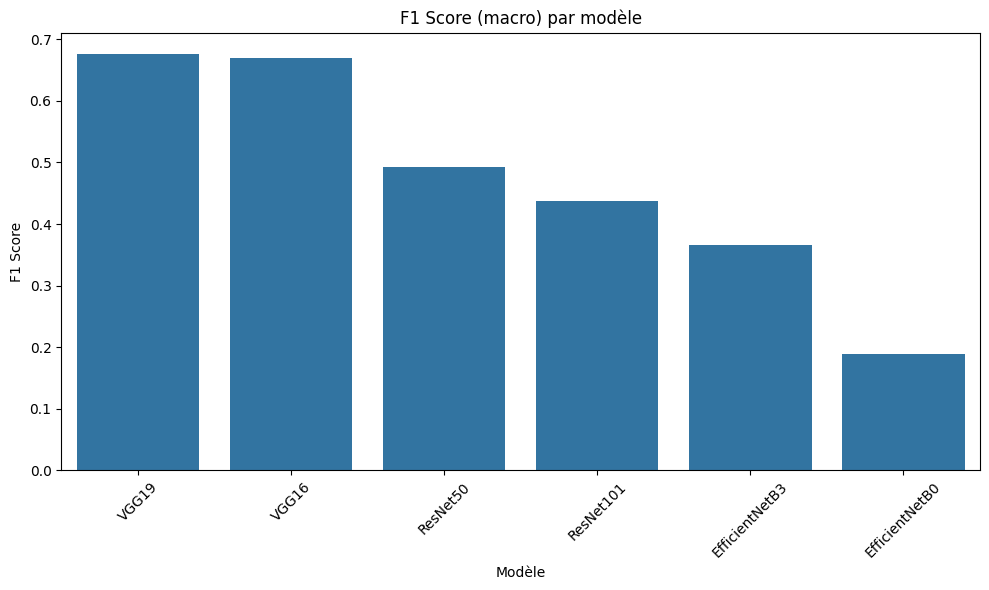

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=df_results.index, y=df_results["F1 Score"])
plt.xticks(rotation=45)
plt.title("F1 Score (macro) par modèle")
plt.ylabel("F1 Score")
plt.xlabel("Modèle")
plt.tight_layout()
plt.savefig("f1_scores_plot.png")
plt.show()


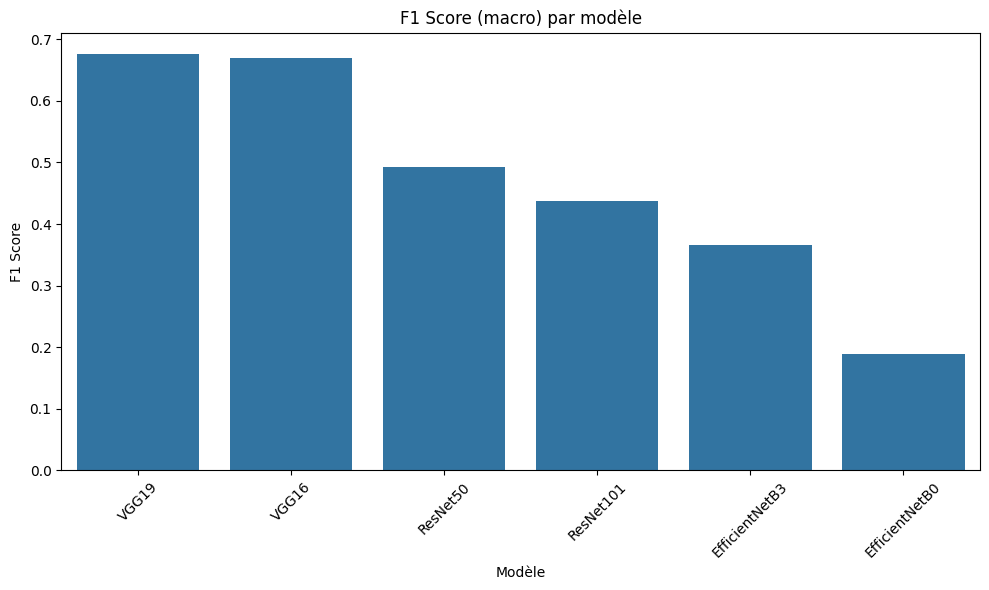

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=df_results.index, y=df_results["F1 Score"])
plt.xticks(rotation=45)
plt.title("F1 Score (macro) par modèle")
plt.ylabel("F1 Score")
plt.xlabel("Modèle")
plt.tight_layout()
plt.savefig("f1_scores_plot.png")
plt.show()


In [8]:
# Chargement du model
model_loaded = tf.keras.models.load_model('../../src/models/benchmark_keras/VGG16_model_final.keras', safe_mode=False)

# Check
model_loaded.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess_2              │ (None, 224, 224, 3)    │             0 │
│ (VGG16Preprocess)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,756,243 (56.29 MB)

 Trainable params: 13,851 (54.11 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 27,704 (108.22 KB)

In [5]:
model_to_plot = "ResNet50"  # exemple
f1_data = np.load("f1_per_class_results.npz")
f1_values = f1_data[model_to_plot]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(range(len(f1_values))), y=f1_values)
plt.title(f"F1 Score par classe pour {model_to_plot}")
plt.xlabel("Classe ID")
plt.ylabel("F1 Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"f1_per_class_{model_to_plot}.png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'f1_per_class_results.npz'